In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
_path = r'C:\Users\DucTRung\Desktop\My_Projects\European_Footboll\data_set\soccer'

In [3]:
# path to save.
_path_fig = r'C:\Users\DucTRung\Desktop\My_Projects\European_Footboll\image'

In [4]:
match_df = pd.read_csv(_path + '\Match.csv', sep='\t')
country_df = pd.read_csv(_path + '\Country.csv', sep='\t')
league_df = pd.read_csv(_path + '\league.csv', sep='\t')
player_df = pd.read_csv(_path + '\Player.csv', sep='\t')
Player_att_df = pd.read_csv(_path + '\Player_Attributes.csv', sep='\t')
team_df = pd.read_csv(_path + '\Team.csv', sep='\t', encoding='latin-1')
team_att_df = pd.read_csv(_path + '\Team_Attributes.csv', sep='\t')

# Purpose: build a model to classify game outcome between three options (Home_win/ Away_win/ Draw).
# Assumption: with more winning match percentage in the past, come more percentage of winning the current game.
## What do I need: 
#### Train set: 
season: 08/09-14/15
team_api_id: home/away
goal: home/away
team_long_name: home/away
winning team
losing team
game outcome
#### Test set:
season: 15/16
winning_pct: home/away

## Subset Columns

In [6]:
# Match data frame
data = match_df[['season',
         'home_team_api_id',
         'away_team_api_id',
         'home_team_goal',
         'away_team_goal']]

In [7]:
# Team data frame
team_name = team_df[['team_api_id', 'team_long_name']]
team_name.head()

team_api_id     team_long_name
0         9987           KRC Genk
1         9993       Beerschot AC
2        10000   SV Zulte-Waregem
3         9994   Sporting Lokeren
4         9984  KSV Cercle Brugge

## Merging

In [8]:
# merge home_team_name
x = pd.merge(data, team_name, left_on='home_team_api_id', right_on='team_api_id', how='left')
x = x.drop('team_api_id', axis=1)
x = x.rename(columns={'team_long_name': 'home_team_name'})

In [9]:
# merge away_team_name
data = pd.merge(x, team_name, left_on='away_team_api_id', right_on='team_api_id', how='left')
data = data.drop('team_api_id', axis=1)
data = data.rename(columns={'team_long_name': 'away_team_name'})

In [10]:
def winning_team(data):
    if data['home_team_goal'] > data['away_team_goal']:
        return data['home_team_name']
    elif data['home_team_goal'] < data['away_team_goal']:
        return data['away_team_name']
    else:
        return 'Draw'
def losing_team(data):
    if data['home_team_goal'] < data['away_team_goal']:
        return data['home_team_name']
    elif data['home_team_goal'] > data['away_team_goal']:
        return data['away_team_name']
    else:
        return 'Draw'
def game_outcome(data):
    if data['home_team_goal'] > data['away_team_goal']:
        return 'Home_win'
    elif data['home_team_goal'] < data['away_team_goal']:
        return 'Away_win'
    else:
        return 'Draw'

In [11]:
data['winning_team'] = data.apply(lambda x: winning_team(x), axis=1)
data['losing_team'] = data.apply(lambda x: losing_team(x), axis=1)
data['game_outcome'] = data.apply(lambda x: game_outcome(x), axis=1)

## Split Train and Test Set

In [12]:
# Split train and test set
train_set = data[data['season'] != '2015/2016']
test_set = data[data['season'] == '2015/2016']

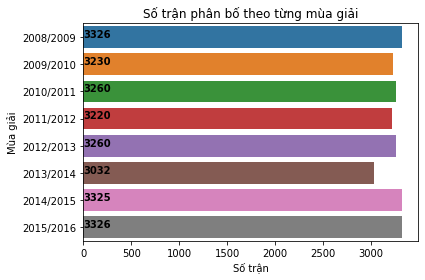

In [13]:
match_season = data['season'].value_counts()
match_season = match_season.reset_index()
match_season = match_season.sort_values(by=['index'])
ax = sns.barplot(x=match_season['season'], y=match_season['index'])
for i, j in enumerate(match_season['season']):
    ax.text(.7, i, j, weight='bold')

plt.title('Số trận phân bố theo từng mùa giải')    
plt.ylabel('Mùa giải')
plt.xlabel('Số trận')

# plt.savefig(_path_fig + '\\total_match.png', bbox_inches='tight')

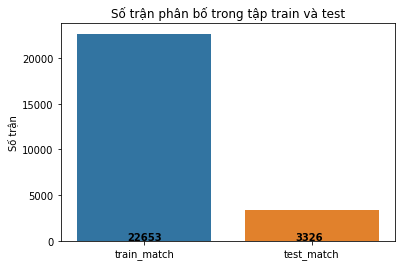

In [14]:
train_match = match_season[:7]
test_match = match_season.iloc[-1]
labels = ['train_match', 'test_match']
y =[train_match['season'].sum(), test_match['season']]
ax = sns.barplot(x=labels, y=y)
for i, j in enumerate(y):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Số trận phân bố trong tập train và test')    
plt.ylabel('Số trận')
plt.xlabel('')
plt.savefig(_path_fig + '\\dis_train_test.png', bbox_inches='tight')

## Analysis Train Set

In [15]:
train_set.head()

season  home_team_api_id  away_team_api_id  home_team_goal  \
0  2008/2009              9987              9993               1   
1  2008/2009             10000              9994               0   
2  2008/2009              9984              8635               0   
3  2008/2009              9991              9998               5   
4  2008/2009              7947              9985               1   

   away_team_goal     home_team_name     away_team_name       winning_team  \
0               1           KRC Genk       Beerschot AC               Draw   
1               0   SV Zulte-Waregem   Sporting Lokeren               Draw   
2               3  KSV Cercle Brugge     RSC Anderlecht     RSC Anderlecht   
3               0           KAA Gent          RAEC Mons           KAA Gent   
4               3      FCV Dender EH  Standard de Liège  Standard de Liège   

         losing_team game_outcome  
0               Draw         Draw  
1               Draw         Draw  
2  KSV Cercle Brugge     Away_win  
3          RAEC Mons     Home_win  
4      FCV Dender EH     Away_win

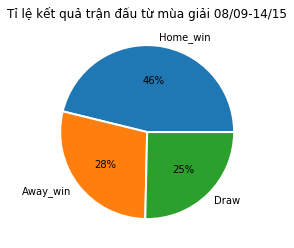

In [16]:
train_set['game_outcome'].value_counts().plot.pie(autopct='%1.0f%%',
                                                  wedgeprops={'linewidth':2, 'edgecolor': 'white'})
plt.title('Tỉ lệ kết quả trận đấu từ mùa giải 08/09-14/15')
plt.ylabel('')
# plt.savefig(_path_fig + '\\out_come_pct.png', bbox_inches='tight')

In [18]:
# Find number of winning and losing each team
win = train_set['winning_team'].value_counts()[1:].reset_index()
lose = train_set['losing_team'].value_counts()[1:].reset_index()

In [19]:
# Find number of draw each team
draw = train_set[train_set['game_outcome'] == 'Draw'][['home_team_name', 'away_team_name']]
draw_h = draw['home_team_name'].value_counts().reset_index()
draw_a = draw['away_team_name'].value_counts().reset_index()

draw_h = draw_h.rename(columns={'home_team_name':'draw'})
draw_a = draw_a.rename(columns={'away_team_name':'draw'})

draw = pd.concat([draw_h, draw_a])
draw = draw.groupby('index')['draw'].sum().reset_index()

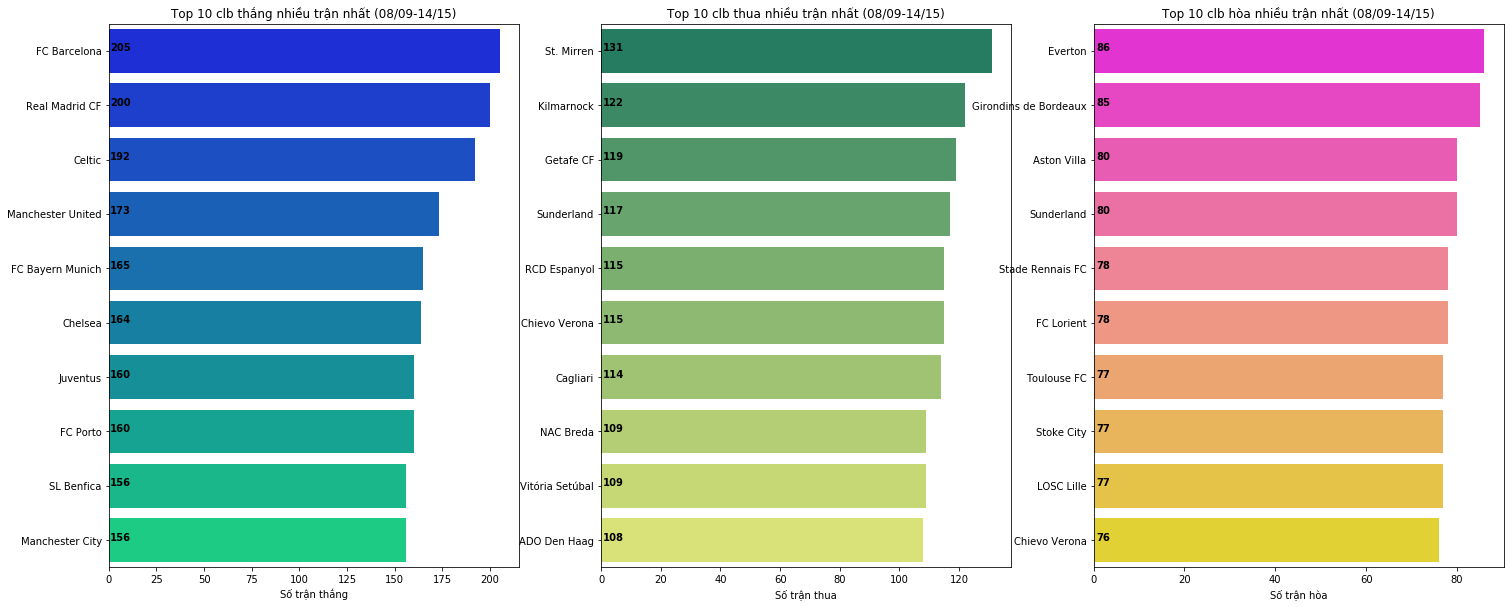

In [20]:
plt.figure(figsize=(25,10))
plt.subplot(1, 3, 1)
top_win = win[:10]
ax = sns.barplot(x=top_win['winning_team'], y=top_win['index'], palette='winter')
for i, j in enumerate(top_win['winning_team']):
    ax.text(.7, i, j, weight='bold')
plt.xlabel('Số trận thắng')
plt.ylabel('')
plt.title('Top 10 clb thắng nhiều trận nhất (08/09-14/15)')
    
plt.subplot(1, 3, 2)
top_lose = lose[:10]
ax = sns.barplot(x=top_lose['losing_team'], y=top_lose['index'], palette='summer')
for i, j in enumerate(top_lose['losing_team']):
    ax.text(.7, i, j, weight='bold')
plt.xlabel('Số trận thua')
plt.ylabel('')
plt.title('Top 10 clb thua nhiều trận nhất (08/09-14/15)')  

plt.subplot(1, 3, 3)
top_draw = draw.sort_values(by=['draw'],ascending=False)[:10]
ax = sns.barplot(x=top_draw['draw'], y=top_draw['index'], palette='spring')
for i, j in enumerate(top_draw['draw']):
    ax.text(.7, i, j, weight='bold')
plt.xlabel('Số trận hòa')
plt.ylabel('')
plt.title('Top 10 clb hòa nhiều trận nhất (08/09-14/15)')

plt.savefig(_path_fig + '\\top_team.png', bbox_inches='tight')

In [21]:
team_name.head()
win.head()
lose.head()
draw['index'].duplicated().sum()

0

In [22]:
# merge win-lose-draw
_team_att = pd.merge(team_name, win, left_on='team_long_name', right_on='index', how='left')
_team_att = pd.merge(_team_att, lose, left_on='team_long_name', right_on='index', how='left')
_team_att = pd.merge(_team_att, draw, left_on='team_long_name', right_on='index', how='left')
team_att = _team_att.drop(['index_x', 'index_y', 'index'], axis=1)
team_att.head()

team_api_id     team_long_name  winning_team  losing_team  draw
0         9987           KRC Genk          83.0         50.0  49.0
1         9993       Beerschot AC          40.0         70.0  42.0
2        10000   SV Zulte-Waregem          66.0         61.0  55.0
3         9994   Sporting Lokeren          66.0         58.0  58.0
4         9984  KSV Cercle Brugge          58.0         90.0  34.0

## Problem: some club have no game at highest league. So it score will be 0.

In [23]:
print('number of newbie teams:', team_att['draw'].isnull().sum())
# fill attributes newbie team to 0.
team_att = team_att.fillna(0)
team_att =team_att.rename(columns={'winning_team':'win',
                        'losing_team':'lose'})

number of newbie teams: 13


In [24]:
team_att['total_match'] = team_att['win'] + team_att['lose'] + team_att['draw']
team_att['win_pct'] = (team_att['win'] / team_att['total_match']) * 100
team_att['lose_pct'] = (team_att['lose'] / team_att['total_match']) * 100
team_att['draw_pct'] = (team_att['draw'] / team_att['total_match']) * 100
team_att['total_pct'] = team_att['lose_pct'] + team_att['win_pct']  +team_att['draw_pct'] 
team_att.head()

team_api_id     team_long_name   win  lose  draw  total_match    win_pct  \
0         9987           KRC Genk  83.0  50.0  49.0        182.0  45.604396   
1         9993       Beerschot AC  40.0  70.0  42.0        152.0  26.315789   
2        10000   SV Zulte-Waregem  66.0  61.0  55.0        182.0  36.263736   
3         9994   Sporting Lokeren  66.0  58.0  58.0        182.0  36.263736   
4         9984  KSV Cercle Brugge  58.0  90.0  34.0        182.0  31.868132   

    lose_pct   draw_pct  total_pct  
0  27.472527  26.923077      100.0  
1  46.052632  27.631579      100.0  
2  33.516484  30.219780      100.0  
3  31.868132  31.868132      100.0  
4  49.450549  18.681319      100.0

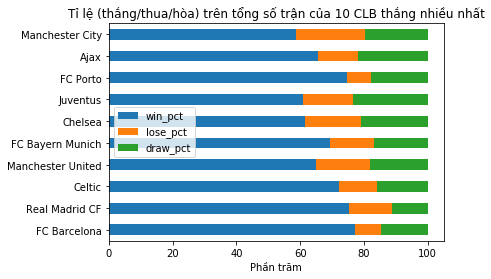

In [25]:
cc = team_att.copy()
cc.index = team_att['team_long_name']

# sort win
cc_win = cc.sort_values(by='win', ascending=False)
cc_win = cc_win[['win_pct', 'lose_pct', 'draw_pct']]
cc_win[:10].plot(kind='barh', stacked=True)

plt.title('Tỉ lệ (thắng/thua/hòa) trên tổng số trận của 10 CLB thắng nhiều nhất')
plt.xlabel('Phần trăm')
plt.ylabel('')

plt.savefig(_path_fig + '\\top_win_att_pct.png', bbox_inches='tight')

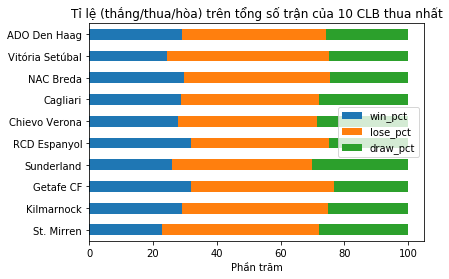

In [26]:
cc_lose = cc.sort_values(by='lose', ascending=False)
cc_lose = cc_lose[['win_pct', 'lose_pct', 'draw_pct']]
cc_lose[:10].plot(kind='barh', stacked=True)

plt.title('Tỉ lệ (thắng/thua/hòa) trên tổng số trận của 10 CLB thua nhất')
plt.xlabel('Phần trăm')
plt.ylabel('')

plt.savefig(_path_fig + '\\top_lose_att_pct.png', bbox_inches='tight')

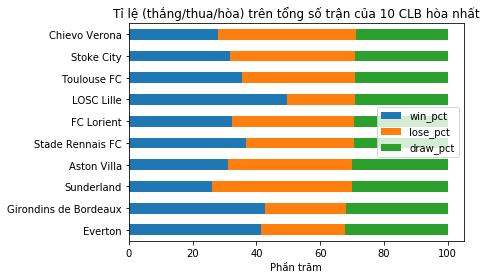

In [27]:
cc_draw = cc.sort_values(by='draw', ascending=False)
cc_draw = cc_draw[['win_pct', 'lose_pct', 'draw_pct']]
cc_draw[:10].plot(kind='barh', stacked=True)

plt.title('Tỉ lệ (thắng/thua/hòa) trên tổng số trận của 10 CLB hòa nhất')
plt.xlabel('Phần trăm')
plt.ylabel('')

plt.savefig(_path_fig + '\\top_draw_att_pct.png', bbox_inches='tight')

Text(0.5, 1.0, 'Tác động của tỉ lệ thắng')

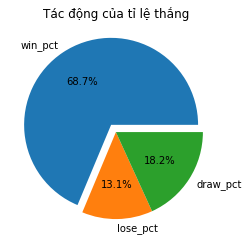

In [28]:
win_pie = cc_win[:10].agg(['mean'])
labels = list(win_pie.columns)
sizes = [int(win_pie[labels[0]]), int(win_pie[labels[1]]), int(win_pie[labels[2]])]
explode = (0.1, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Tác động của tỉ lệ thắng')

# plt.savefig(_path_fig + '\\win_pie.png', bbox_inches='tight')

Text(0.5, 1.0, 'Tác động của tỉ lệ thua')

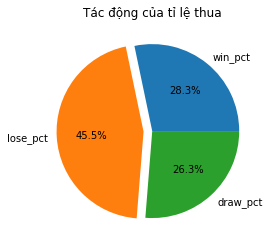

In [29]:
lose_pie = cc_lose[:10].agg(['mean'])
labels = list(lose_pie.columns)
sizes = [int(lose_pie[labels[0]]), int(lose_pie[labels[1]]), int(lose_pie[labels[2]])]
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Tác động của tỉ lệ thua')

# plt.savefig(_path_fig + '\\lose_pie.png', bbox_inches='tight')

Text(0.5, 1.0, 'Tác động của tỉ lệ hòa')

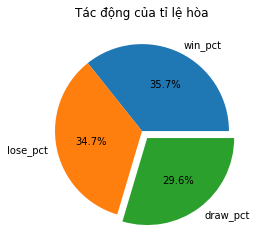

In [30]:
draw_pie = cc_draw[:10].agg(['mean'])
labels = list(draw_pie.columns)
sizes = [int(draw_pie[labels[0]]), int(draw_pie[labels[1]]), int(draw_pie[labels[2]])]
explode = (0, 0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Tác động của tỉ lệ hòa')

# plt.savefig(_path_fig + '\\draw_pie.png', bbox_inches='tight')

In [31]:
print('number of newbie teams:', team_att['draw'].isnull().sum())
# fill attributes newbie team to 0.
team_att = team_att.fillna(0)
team_att.head()
win_pct = team_att[['team_long_name', 'win_pct']]
win_pct

number of newbie teams: 0


team_long_name    win_pct
0              KRC Genk  45.604396
1          Beerschot AC  26.315789
2      SV Zulte-Waregem  36.263736
3      Sporting Lokeren  36.263736
4     KSV Cercle Brugge  31.868132
..                  ...        ...
294       FC St. Gallen  34.444444
295             FC Thun  34.269663
296         Servette FC  28.571429
297  FC Lausanne-Sports  21.698113
298              Lugano   0.000000

[299 rows x 2 columns]

##  Predict

In [32]:
test_set.head()

season  home_team_api_id  away_team_api_id  home_team_goal  \
1488  2015/2016              9997              8342               2   
1489  2015/2016              8571              9985               2   
1490  2015/2016              9987              1773               3   
1491  2015/2016              8573              8203               3   
1492  2015/2016             10000              9994               3   

      away_team_goal     home_team_name       away_team_name  \
1488               1  Sint-Truidense VV       Club Brugge KV   
1489               1        KV Kortrijk    Standard de Liège   
1490               1           KRC Genk  Oud-Heverlee Leuven   
1491               1        KV Oostende          KV Mechelen   
1492               1   SV Zulte-Waregem     Sporting Lokeren   

           winning_team          losing_team game_outcome  
1488  Sint-Truidense VV       Club Brugge KV     Home_win  
1489        KV Kortrijk    Standard de Liège     Home_win  
1490           KRC Genk  Oud-Heverlee Leuven     Home_win  
1491        KV Oostende          KV Mechelen     Home_win  
1492   SV Zulte-Waregem     Sporting Lokeren     Home_win

In [33]:
x = pd.merge(test_set, win_pct, left_on='home_team_name', right_on='team_long_name', how='left')
test_set = pd.merge(x, win_pct, left_on='away_team_name', right_on='team_long_name', how='left')

In [34]:
test_set = test_set.drop(['team_long_name_x', 'team_long_name_y'], axis=1)
test_set = test_set.rename(columns={'win_pct_x': 'home_win_pct',
                           'win_pct_y': 'away_win_pct'})

In [35]:
def predict(data):
    if data['home_win_pct'] > data['away_win_pct']:
        return 'Home_win'
    elif data['home_win_pct'] < data['away_win_pct']:
        return 'Away_win'
    else:
        return 'Draw'

In [36]:
test_set['predict'] = test_set.apply(lambda x: predict(x), axis=1)

In [37]:
test_set.head()

season  home_team_api_id  away_team_api_id  home_team_goal  \
0  2015/2016              9997              8342               2   
1  2015/2016              8571              9985               2   
2  2015/2016              9987              1773               3   
3  2015/2016              8573              8203               3   
4  2015/2016             10000              9994               3   

   away_team_goal     home_team_name       away_team_name       winning_team  \
0               1  Sint-Truidense VV       Club Brugge KV  Sint-Truidense VV   
1               1        KV Kortrijk    Standard de Liège        KV Kortrijk   
2               1           KRC Genk  Oud-Heverlee Leuven           KRC Genk   
3               1        KV Oostende          KV Mechelen        KV Oostende   
4               1   SV Zulte-Waregem     Sporting Lokeren   SV Zulte-Waregem   

           losing_team game_outcome  home_win_pct  away_win_pct   predict  
0       Club Brugge KV     Home_win     26.136364     56.043956  Away_win  
1    Standard de Liège     Home_win     39.560440     51.648352  Away_win  
2  Oud-Heverlee Leuven     Home_win     45.604396     25.000000  Home_win  
3          KV Mechelen     Home_win     41.666667     37.912088  Home_win  
4     Sporting Lokeren     Home_win     36.263736     36.263736      Draw

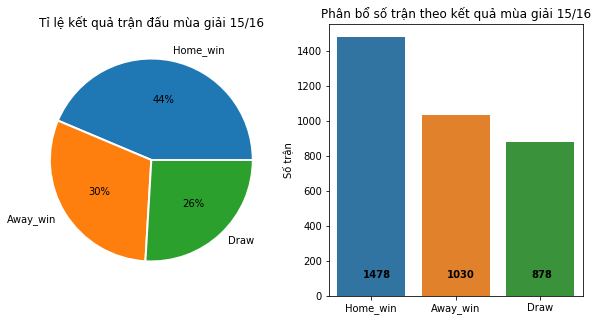

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
test_set['game_outcome'].value_counts().plot.pie(autopct='%1.0f%%',
                                                  wedgeprops={'linewidth':2, 'edgecolor': 'white'})
plt.title('Tỉ lệ kết quả trận đấu mùa giải 15/16')
plt.ylabel('')

plt.subplot(1, 2, 2)
count = test_set['game_outcome'].value_counts().reset_index()
ax = sns.barplot(x=count['index'], y=count.game_outcome)
for i, j in enumerate(count.game_outcome):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Phân bổ số trận theo kết quả mùa giải 15/16')
plt.xlabel("")
plt.ylabel('Số trận')

plt.subplots_adjust(hspace=10)
plt.savefig(_path_fig + '\\actually_out_come_pct.png', bbox_inches='tight')

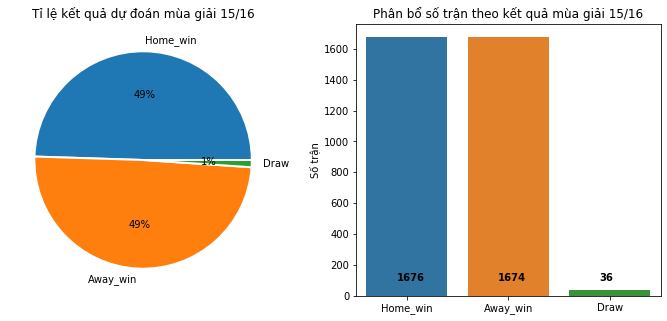

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
test_set['predict'].value_counts().plot.pie(autopct='%1.0f%%',
                                            wedgeprops={'linewidth':2, 'edgecolor': 'white'})
plt.title('Tỉ lệ kết quả dự đoán mùa giải 15/16')
plt.ylabel('')

plt.subplot(1, 2, 2)
count = test_set['predict'].value_counts().reset_index()
ax = sns.barplot(x=count['index'], y=count.predict)
for i, j in enumerate(count.predict):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Phân bổ số trận theo kết quả mùa giải 15/16')
plt.xlabel("")
plt.ylabel('Số trận')

plt.subplots_adjust(hspace=10)
plt.savefig(_path_fig + '\\predict_out_come_pct.png', bbox_inches='tight')

# Evaluation

In [40]:
def measure(test_set):
    if test_set['game_outcome'] == test_set['predict']:
        return 1
    elif test_set['game_outcome'] != test_set['predict']:
        return 0

In [41]:
test_set['result'] = test_set.apply(lambda x: measure(x), axis=1)
test_set['home_win_result'] = test_set[test_set['predict'] == 'Home_win'].apply(lambda x: measure(x), axis=1)
test_set['away_win_result'] = test_set[test_set['predict'] == 'Away_win'].apply(lambda x: measure(x), axis=1)
test_set['draw_result'] = test_set[test_set['predict'] == 'Draw'].apply(lambda x: measure(x), axis=1)

## General

x: 0    1793
1    1593
Name: result, dtype: int64
acc: 47.04666272888364


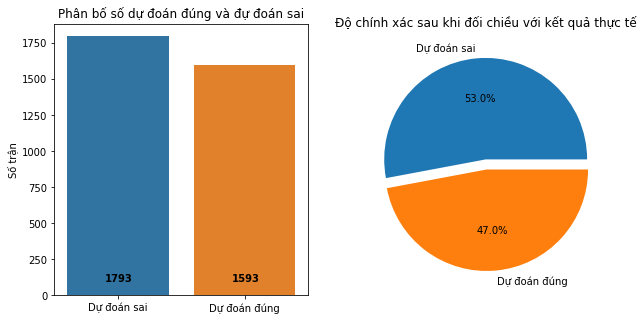

In [42]:
x = test_set['result'].value_counts().sort_index(ascending=True)
print('x:', x)
# accuracy
acc = (x[1] / len(test_set.index)) * 100
print('acc:', acc)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Dự đoán sai', 'Dự đoán đúng']
ax = sns.barplot(x=labels, y=x)
for i, j in enumerate(x):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Phân bố số dự đoán đúng và đự đoán sai')    
plt.ylabel('Số trận')
plt.xlabel('')

plt.subplot(1, 2, 2)
labels = ['Dự đoán sai', 'Dự đoán đúng']
sizes = [100-acc, acc]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Độ chính xác sau khi đối chiều với kết quả thực tế')
plt.savefig(_path_fig + '\\result_general.png', bbox_inches='tight')

## Home Win

x: 0.0    761
1.0    915
Name: home_win_result, dtype: int64
acc: 54.59427207637232


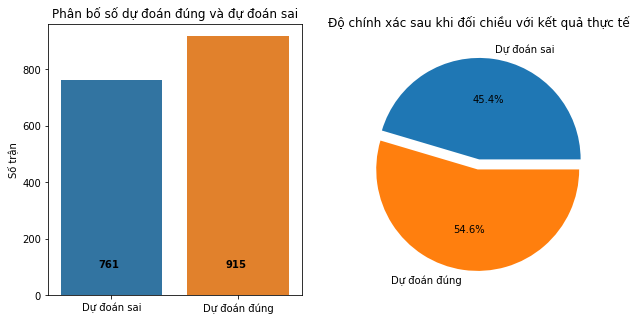

In [43]:
x = test_set['home_win_result'].value_counts().sort_index(ascending=True)
print('x:', x)
acc = (x[1] / len(test_set[test_set['predict'] == 'Home_win'].index)) * 100
print('acc:', acc)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Dự đoán sai', 'Dự đoán đúng']
ax = sns.barplot(x=labels, y=x)
for i, j in enumerate(x):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Phân bố số dự đoán đúng và đự đoán sai')    
plt.ylabel('Số trận')
plt.xlabel('')

plt.subplot(1, 2, 2)
labels = ['Dự đoán sai', 'Dự đoán đúng']
sizes = [100-acc, acc]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Độ chính xác sau khi đối chiều với kết quả thực tế')
plt.savefig(_path_fig + '\\result_home_win.png', bbox_inches='tight')

## Away Win

x: 0.0    1006
1.0     668
Name: away_win_result, dtype: int64
acc: 39.904420549581836


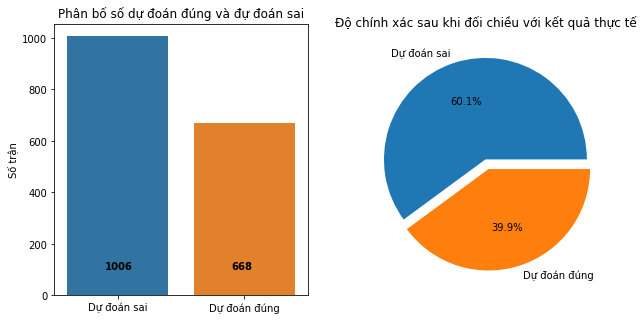

In [44]:
x = test_set['away_win_result'].value_counts().sort_index(ascending=True)
print('x:', x)
acc = (x[1] / len(test_set[test_set['predict'] == 'Away_win'].index)) * 100
print('acc:', acc)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Dự đoán sai', 'Dự đoán đúng']
ax = sns.barplot(x=labels, y=x)
for i, j in enumerate(x):
    ax.text(i-0.1, 100, j, weight='bold')
plt.title('Phân bố số dự đoán đúng và đự đoán sai')    
plt.ylabel('Số trận')
plt.xlabel('')

plt.subplot(1, 2, 2)
labels = ['Dự đoán sai', 'Dự đoán đúng']
sizes = [100-acc, acc]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Độ chính xác sau khi đối chiều với kết quả thực tế')
plt.savefig(_path_fig + '\\result_away_win.png', bbox_inches='tight')

## Draw

x: 0.0    26
1.0    10
Name: draw_result, dtype: int64
acc: 27.77777777777778


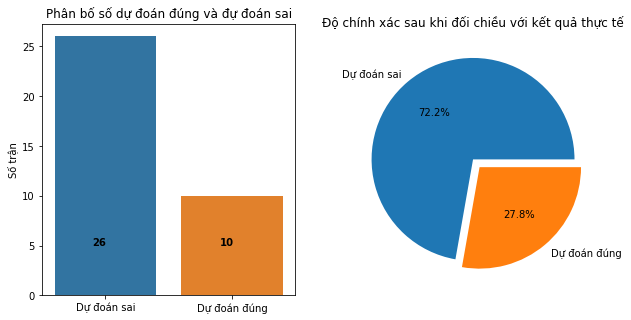

In [50]:
x = test_set['draw_result'].value_counts().sort_index(ascending=True)
print('x:', x)
acc = (x[1] / len(test_set[test_set['predict'] == 'Draw'].index)) * 100
print('acc:', acc)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Dự đoán sai', 'Dự đoán đúng']
ax = sns.barplot(x=labels, y=x)
for i, j in enumerate(x):
    ax.text(i-0.1, 5, j, weight='bold')
plt.title('Phân bố số dự đoán đúng và đự đoán sai')    
plt.ylabel('Số trận')
plt.xlabel('')

plt.subplot(1, 2, 2)
labels = ['Dự đoán sai', 'Dự đoán đúng']
sizes = [100-acc, acc]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.title('Độ chính xác sau khi đối chiều với kết quả thực tế')

plt.savefig(_path_fig + '\\result_drawn.png', bbox_inches='tight')